# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

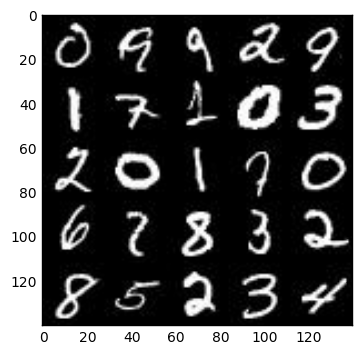

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

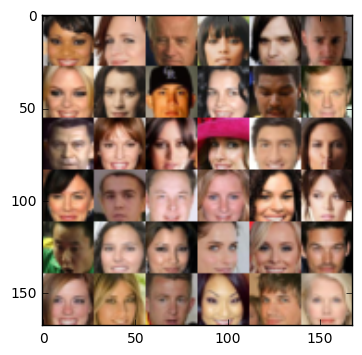

In [3]:
show_n_images = 40

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], "input_real")
    input_z = tf.placeholder(tf.float32, [None, z_dim], "input_z")
    learning_rate = tf.placeholder(tf.float32, None, "learning_rate")

    return (input_real, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    
    def conv(inputs, filters, batch_norm=True):
        outputs = tf.layers.conv2d(inputs, filters, 5, 2, 'same')
        if batch_norm:
            outputs = tf.layers.batch_normalization(outputs, training=True)
        return leaky_relu(outputs)
        
    
    with tf.variable_scope("discriminator", reuse=reuse):
        # input 28*28*3
        x1 = conv(images, 64, batch_norm=False) # 14*14*64
        x2 = conv(x1, 128) # 7*7*128
        x3 = conv(x2, 256) # 4*4*256
        
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return (out, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    leaky_relu = lambda x: tf.maximum(alpha * x, x)
    with tf.variable_scope("generator", reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1)
        # 7*7*512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, 1, 'SAME')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2)
        # 7*7*256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, 2, 'SAME')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3)
        # 14*14*128
    
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, 2, 'SAME')
        out = tf.tanh(logits)
        # 28*28*out_channel_dim
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.9):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real) * alpha))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    return (d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        t_vars = tf.trainable_variables()
        
        d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
        g_vars = [var for var in t_vars if var.name.startswith('generator')]

        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        return (d_train_opt, g_train_opt)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                
                if steps % 10 == 0:
                    train_loss_d = d_loss.eval({input_real: batch_images, input_z: batch_z})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Batch {}...".format(steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, data_shape[3], data_image_mode)
                
                
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Batch 10... Discriminator Loss: 3.7893... Generator Loss: 0.0760
Epoch 1/2... Batch 20... Discriminator Loss: 1.1052... Generator Loss: 1.6648
Epoch 1/2... Batch 30... Discriminator Loss: 0.4713... Generator Loss: 3.8981
Epoch 1/2... Batch 40... Discriminator Loss: 2.6040... Generator Loss: 0.3476
Epoch 1/2... Batch 50... Discriminator Loss: 0.7727... Generator Loss: 4.8056
Epoch 1/2... Batch 60... Discriminator Loss: 0.7517... Generator Loss: 1.7215
Epoch 1/2... Batch 70... Discriminator Loss: 0.6651... Generator Loss: 3.0028
Epoch 1/2... Batch 80... Discriminator Loss: 1.3421... Generator Loss: 0.7767
Epoch 1/2... Batch 90... Discriminator Loss: 1.6541... Generator Loss: 0.4184
Epoch 1/2... Batch 100... Discriminator Loss: 1.3106... Generator Loss: 0.7652


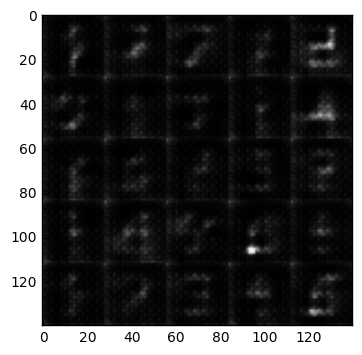

Epoch 1/2... Batch 110... Discriminator Loss: 0.8679... Generator Loss: 1.6608
Epoch 1/2... Batch 120... Discriminator Loss: 1.0051... Generator Loss: 1.0443
Epoch 1/2... Batch 130... Discriminator Loss: 1.3564... Generator Loss: 0.8837
Epoch 1/2... Batch 140... Discriminator Loss: 1.0896... Generator Loss: 1.2278
Epoch 1/2... Batch 150... Discriminator Loss: 1.3976... Generator Loss: 2.4436
Epoch 1/2... Batch 160... Discriminator Loss: 1.3042... Generator Loss: 0.7195
Epoch 1/2... Batch 170... Discriminator Loss: 1.3538... Generator Loss: 0.6468
Epoch 1/2... Batch 180... Discriminator Loss: 1.4578... Generator Loss: 2.1713
Epoch 1/2... Batch 190... Discriminator Loss: 1.3125... Generator Loss: 0.6187
Epoch 1/2... Batch 200... Discriminator Loss: 1.1508... Generator Loss: 1.5070


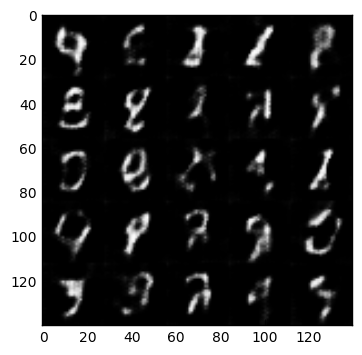

Epoch 1/2... Batch 210... Discriminator Loss: 1.3312... Generator Loss: 0.7095
Epoch 1/2... Batch 220... Discriminator Loss: 1.3411... Generator Loss: 0.6778
Epoch 1/2... Batch 230... Discriminator Loss: 1.2390... Generator Loss: 1.0288
Epoch 1/2... Batch 240... Discriminator Loss: 1.1693... Generator Loss: 1.0265
Epoch 1/2... Batch 250... Discriminator Loss: 1.0888... Generator Loss: 0.9012
Epoch 1/2... Batch 260... Discriminator Loss: 1.1413... Generator Loss: 0.9085
Epoch 1/2... Batch 270... Discriminator Loss: 1.2659... Generator Loss: 1.7134
Epoch 1/2... Batch 280... Discriminator Loss: 1.3190... Generator Loss: 0.6972
Epoch 1/2... Batch 290... Discriminator Loss: 1.7139... Generator Loss: 0.3519
Epoch 1/2... Batch 300... Discriminator Loss: 1.2404... Generator Loss: 0.7334


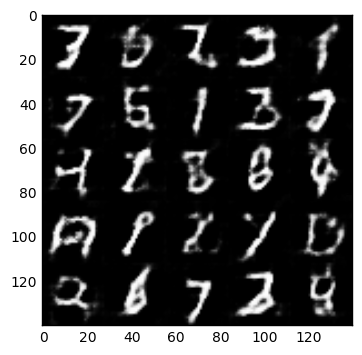

Epoch 1/2... Batch 310... Discriminator Loss: 1.1719... Generator Loss: 1.3036
Epoch 1/2... Batch 320... Discriminator Loss: 1.2260... Generator Loss: 0.9140
Epoch 1/2... Batch 330... Discriminator Loss: 1.1239... Generator Loss: 1.3693
Epoch 1/2... Batch 340... Discriminator Loss: 1.3215... Generator Loss: 0.6021
Epoch 1/2... Batch 350... Discriminator Loss: 1.4596... Generator Loss: 1.8716
Epoch 1/2... Batch 360... Discriminator Loss: 1.2602... Generator Loss: 0.7121
Epoch 1/2... Batch 370... Discriminator Loss: 1.1765... Generator Loss: 1.0032
Epoch 1/2... Batch 380... Discriminator Loss: 1.1916... Generator Loss: 1.0384
Epoch 1/2... Batch 390... Discriminator Loss: 1.2352... Generator Loss: 0.7526
Epoch 1/2... Batch 400... Discriminator Loss: 1.0967... Generator Loss: 1.2241


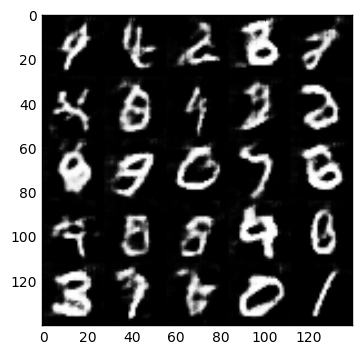

Epoch 1/2... Batch 410... Discriminator Loss: 1.2729... Generator Loss: 0.6199
Epoch 1/2... Batch 420... Discriminator Loss: 1.2073... Generator Loss: 1.2713
Epoch 1/2... Batch 430... Discriminator Loss: 1.2401... Generator Loss: 1.4193
Epoch 1/2... Batch 440... Discriminator Loss: 1.1357... Generator Loss: 1.2541
Epoch 1/2... Batch 450... Discriminator Loss: 1.1824... Generator Loss: 0.7646
Epoch 1/2... Batch 460... Discriminator Loss: 1.1887... Generator Loss: 1.0273
Epoch 2/2... Batch 10... Discriminator Loss: 1.2976... Generator Loss: 1.2153
Epoch 2/2... Batch 20... Discriminator Loss: 1.1259... Generator Loss: 0.9985
Epoch 2/2... Batch 30... Discriminator Loss: 1.2876... Generator Loss: 1.5340
Epoch 2/2... Batch 40... Discriminator Loss: 1.1980... Generator Loss: 0.7897
Epoch 2/2... Batch 50... Discriminator Loss: 1.1458... Generator Loss: 1.1075
Epoch 2/2... Batch 60... Discriminator Loss: 1.8071... Generator Loss: 0.3201
Epoch 2/2... Batch 70... Discriminator Loss: 1.1674... Gen

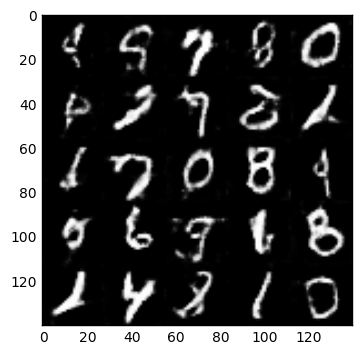

Epoch 2/2... Batch 110... Discriminator Loss: 1.1918... Generator Loss: 0.7668
Epoch 2/2... Batch 120... Discriminator Loss: 1.2226... Generator Loss: 0.7288
Epoch 2/2... Batch 130... Discriminator Loss: 1.3979... Generator Loss: 0.4966
Epoch 2/2... Batch 140... Discriminator Loss: 1.1053... Generator Loss: 0.9396
Epoch 2/2... Batch 150... Discriminator Loss: 1.1657... Generator Loss: 0.7309
Epoch 2/2... Batch 160... Discriminator Loss: 1.9163... Generator Loss: 0.2898
Epoch 2/2... Batch 170... Discriminator Loss: 1.2493... Generator Loss: 0.9559
Epoch 2/2... Batch 180... Discriminator Loss: 1.3345... Generator Loss: 0.6623
Epoch 2/2... Batch 190... Discriminator Loss: 1.1977... Generator Loss: 0.9003
Epoch 2/2... Batch 200... Discriminator Loss: 1.1948... Generator Loss: 1.3368


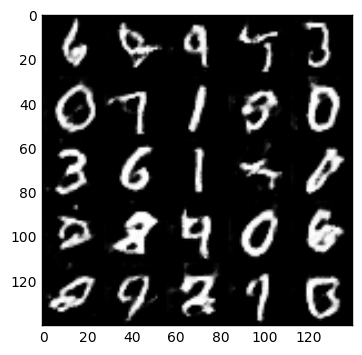

Epoch 2/2... Batch 210... Discriminator Loss: 1.4643... Generator Loss: 0.4803
Epoch 2/2... Batch 220... Discriminator Loss: 1.1456... Generator Loss: 1.3340
Epoch 2/2... Batch 230... Discriminator Loss: 1.2049... Generator Loss: 1.1629
Epoch 2/2... Batch 240... Discriminator Loss: 1.1768... Generator Loss: 0.7893
Epoch 2/2... Batch 250... Discriminator Loss: 1.1979... Generator Loss: 1.2739
Epoch 2/2... Batch 260... Discriminator Loss: 1.1192... Generator Loss: 1.1684
Epoch 2/2... Batch 270... Discriminator Loss: 1.7510... Generator Loss: 0.3563
Epoch 2/2... Batch 280... Discriminator Loss: 1.1588... Generator Loss: 0.7849
Epoch 2/2... Batch 290... Discriminator Loss: 1.7949... Generator Loss: 0.3330
Epoch 2/2... Batch 300... Discriminator Loss: 1.1276... Generator Loss: 0.8482


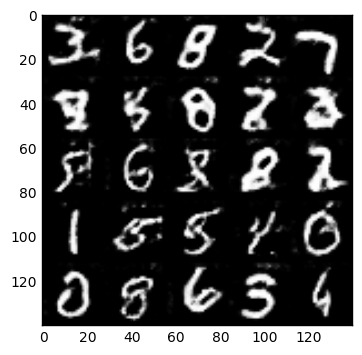

Epoch 2/2... Batch 310... Discriminator Loss: 1.1679... Generator Loss: 0.8163
Epoch 2/2... Batch 320... Discriminator Loss: 1.0503... Generator Loss: 1.2518
Epoch 2/2... Batch 330... Discriminator Loss: 1.1514... Generator Loss: 0.7618
Epoch 2/2... Batch 340... Discriminator Loss: 1.4902... Generator Loss: 0.4480
Epoch 2/2... Batch 350... Discriminator Loss: 1.1393... Generator Loss: 0.9414
Epoch 2/2... Batch 360... Discriminator Loss: 1.1414... Generator Loss: 0.9042
Epoch 2/2... Batch 370... Discriminator Loss: 1.2319... Generator Loss: 0.7094
Epoch 2/2... Batch 380... Discriminator Loss: 1.2219... Generator Loss: 0.7191
Epoch 2/2... Batch 390... Discriminator Loss: 1.4162... Generator Loss: 0.4942
Epoch 2/2... Batch 400... Discriminator Loss: 1.1352... Generator Loss: 1.2978


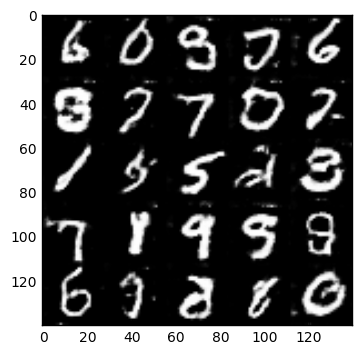

Epoch 2/2... Batch 410... Discriminator Loss: 1.1386... Generator Loss: 0.7847
Epoch 2/2... Batch 420... Discriminator Loss: 1.1751... Generator Loss: 1.1154
Epoch 2/2... Batch 430... Discriminator Loss: 1.6945... Generator Loss: 0.3562
Epoch 2/2... Batch 440... Discriminator Loss: 1.0440... Generator Loss: 1.0960
Epoch 2/2... Batch 450... Discriminator Loss: 1.0058... Generator Loss: 1.2821
Epoch 2/2... Batch 460... Discriminator Loss: 1.1650... Generator Loss: 0.9152


In [13]:
batch_size = 128
z_dim = 128
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Batch 10... Discriminator Loss: 0.7088... Generator Loss: 1.8466
Epoch 1/1... Batch 20... Discriminator Loss: 0.5572... Generator Loss: 10.4499
Epoch 1/1... Batch 30... Discriminator Loss: 0.8030... Generator Loss: 14.7792
Epoch 1/1... Batch 40... Discriminator Loss: 0.7964... Generator Loss: 6.8221
Epoch 1/1... Batch 50... Discriminator Loss: 1.2787... Generator Loss: 0.9807
Epoch 1/1... Batch 60... Discriminator Loss: 1.9336... Generator Loss: 0.6087
Epoch 1/1... Batch 70... Discriminator Loss: 1.1619... Generator Loss: 0.9629
Epoch 1/1... Batch 80... Discriminator Loss: 1.0694... Generator Loss: 0.9024
Epoch 1/1... Batch 90... Discriminator Loss: 1.5849... Generator Loss: 4.0422
Epoch 1/1... Batch 100... Discriminator Loss: 1.4372... Generator Loss: 0.5948


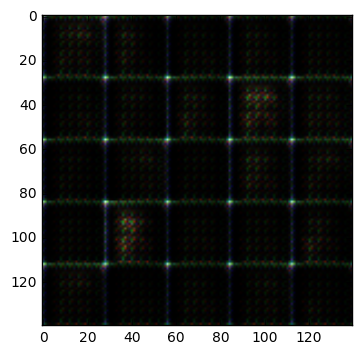

Epoch 1/1... Batch 110... Discriminator Loss: 1.0796... Generator Loss: 1.2805
Epoch 1/1... Batch 120... Discriminator Loss: 0.9881... Generator Loss: 1.2735
Epoch 1/1... Batch 130... Discriminator Loss: 1.2886... Generator Loss: 0.8885
Epoch 1/1... Batch 140... Discriminator Loss: 1.1509... Generator Loss: 0.9582
Epoch 1/1... Batch 150... Discriminator Loss: 1.3900... Generator Loss: 0.7520
Epoch 1/1... Batch 160... Discriminator Loss: 1.1535... Generator Loss: 1.5699
Epoch 1/1... Batch 170... Discriminator Loss: 0.9807... Generator Loss: 1.1541
Epoch 1/1... Batch 180... Discriminator Loss: 1.0082... Generator Loss: 1.3184
Epoch 1/1... Batch 190... Discriminator Loss: 1.1514... Generator Loss: 0.8728
Epoch 1/1... Batch 200... Discriminator Loss: 1.2380... Generator Loss: 1.1814


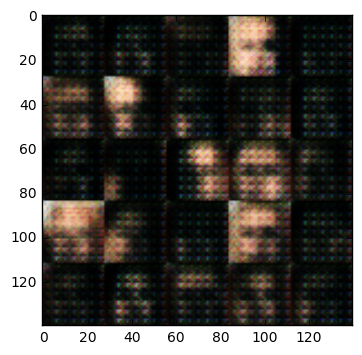

Epoch 1/1... Batch 210... Discriminator Loss: 1.1058... Generator Loss: 1.1652
Epoch 1/1... Batch 220... Discriminator Loss: 1.0899... Generator Loss: 1.4773
Epoch 1/1... Batch 230... Discriminator Loss: 0.9885... Generator Loss: 2.7755
Epoch 1/1... Batch 240... Discriminator Loss: 1.4520... Generator Loss: 0.5172
Epoch 1/1... Batch 250... Discriminator Loss: 1.1353... Generator Loss: 0.8407
Epoch 1/1... Batch 260... Discriminator Loss: 1.2010... Generator Loss: 0.7521
Epoch 1/1... Batch 270... Discriminator Loss: 1.3725... Generator Loss: 0.6369
Epoch 1/1... Batch 280... Discriminator Loss: 1.2869... Generator Loss: 0.6393
Epoch 1/1... Batch 290... Discriminator Loss: 1.0140... Generator Loss: 1.2776
Epoch 1/1... Batch 300... Discriminator Loss: 1.1677... Generator Loss: 1.1581


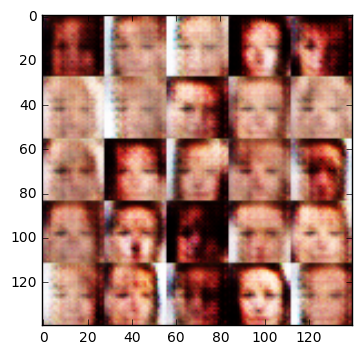

Epoch 1/1... Batch 310... Discriminator Loss: 1.9129... Generator Loss: 3.3262
Epoch 1/1... Batch 320... Discriminator Loss: 1.3176... Generator Loss: 0.6166
Epoch 1/1... Batch 330... Discriminator Loss: 0.9681... Generator Loss: 1.6249
Epoch 1/1... Batch 340... Discriminator Loss: 1.2403... Generator Loss: 0.7245
Epoch 1/1... Batch 350... Discriminator Loss: 0.9894... Generator Loss: 0.9918
Epoch 1/1... Batch 360... Discriminator Loss: 1.4047... Generator Loss: 0.5822
Epoch 1/1... Batch 370... Discriminator Loss: 0.6711... Generator Loss: 1.9191
Epoch 1/1... Batch 380... Discriminator Loss: 1.2680... Generator Loss: 0.6711
Epoch 1/1... Batch 390... Discriminator Loss: 1.2758... Generator Loss: 0.7047
Epoch 1/1... Batch 400... Discriminator Loss: 2.6768... Generator Loss: 0.1417


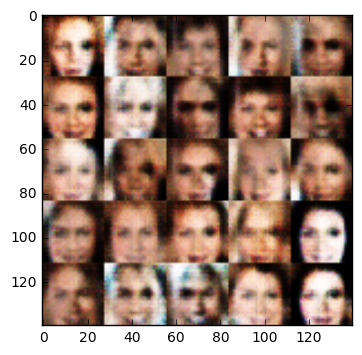

Epoch 1/1... Batch 410... Discriminator Loss: 1.2232... Generator Loss: 0.8595
Epoch 1/1... Batch 420... Discriminator Loss: 1.1429... Generator Loss: 0.7283
Epoch 1/1... Batch 430... Discriminator Loss: 0.7747... Generator Loss: 1.4161
Epoch 1/1... Batch 440... Discriminator Loss: 1.0089... Generator Loss: 3.5561
Epoch 1/1... Batch 450... Discriminator Loss: 1.1595... Generator Loss: 2.8382
Epoch 1/1... Batch 460... Discriminator Loss: 1.0611... Generator Loss: 2.7244
Epoch 1/1... Batch 470... Discriminator Loss: 1.4968... Generator Loss: 3.1830
Epoch 1/1... Batch 480... Discriminator Loss: 1.6326... Generator Loss: 0.4109
Epoch 1/1... Batch 490... Discriminator Loss: 0.9241... Generator Loss: 2.0713
Epoch 1/1... Batch 500... Discriminator Loss: 1.4505... Generator Loss: 1.2702


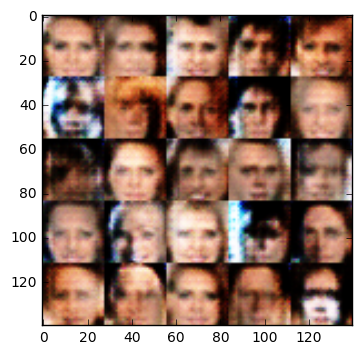

Epoch 1/1... Batch 510... Discriminator Loss: 0.6662... Generator Loss: 2.2793
Epoch 1/1... Batch 520... Discriminator Loss: 0.7648... Generator Loss: 1.3813
Epoch 1/1... Batch 530... Discriminator Loss: 1.2822... Generator Loss: 0.7527
Epoch 1/1... Batch 540... Discriminator Loss: 0.7916... Generator Loss: 1.5400
Epoch 1/1... Batch 550... Discriminator Loss: 1.0207... Generator Loss: 2.1071
Epoch 1/1... Batch 560... Discriminator Loss: 1.7796... Generator Loss: 2.4914
Epoch 1/1... Batch 570... Discriminator Loss: 1.4035... Generator Loss: 1.8028
Epoch 1/1... Batch 580... Discriminator Loss: 1.3255... Generator Loss: 0.6869
Epoch 1/1... Batch 590... Discriminator Loss: 1.3143... Generator Loss: 0.7498
Epoch 1/1... Batch 600... Discriminator Loss: 1.1256... Generator Loss: 0.9605


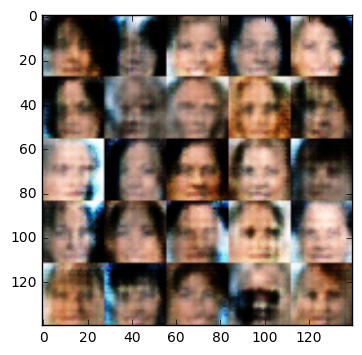

Epoch 1/1... Batch 610... Discriminator Loss: 1.2171... Generator Loss: 0.6634
Epoch 1/1... Batch 620... Discriminator Loss: 1.3346... Generator Loss: 1.3274
Epoch 1/1... Batch 630... Discriminator Loss: 1.1956... Generator Loss: 1.2139
Epoch 1/1... Batch 640... Discriminator Loss: 1.0019... Generator Loss: 1.1723
Epoch 1/1... Batch 650... Discriminator Loss: 1.5225... Generator Loss: 0.4563
Epoch 1/1... Batch 660... Discriminator Loss: 1.3560... Generator Loss: 0.5666
Epoch 1/1... Batch 670... Discriminator Loss: 0.6099... Generator Loss: 2.1744
Epoch 1/1... Batch 680... Discriminator Loss: 0.9460... Generator Loss: 0.9429
Epoch 1/1... Batch 690... Discriminator Loss: 1.1678... Generator Loss: 1.1863
Epoch 1/1... Batch 700... Discriminator Loss: 0.9578... Generator Loss: 1.3724


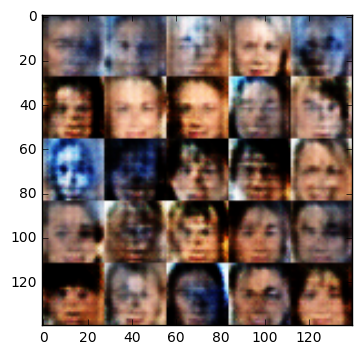

Epoch 1/1... Batch 710... Discriminator Loss: 1.0727... Generator Loss: 1.5068
Epoch 1/1... Batch 720... Discriminator Loss: 1.2322... Generator Loss: 0.8282
Epoch 1/1... Batch 730... Discriminator Loss: 1.4229... Generator Loss: 0.6914
Epoch 1/1... Batch 740... Discriminator Loss: 1.1650... Generator Loss: 1.2924
Epoch 1/1... Batch 750... Discriminator Loss: 1.2531... Generator Loss: 0.7925
Epoch 1/1... Batch 760... Discriminator Loss: 0.9587... Generator Loss: 1.1283
Epoch 1/1... Batch 770... Discriminator Loss: 1.1165... Generator Loss: 0.9098
Epoch 1/1... Batch 780... Discriminator Loss: 1.1706... Generator Loss: 1.8160
Epoch 1/1... Batch 790... Discriminator Loss: 0.8233... Generator Loss: 2.4064
Epoch 1/1... Batch 800... Discriminator Loss: 1.2343... Generator Loss: 1.3447


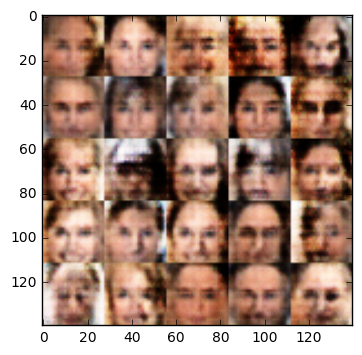

Epoch 1/1... Batch 810... Discriminator Loss: 1.0188... Generator Loss: 0.9217
Epoch 1/1... Batch 820... Discriminator Loss: 1.4142... Generator Loss: 2.9589
Epoch 1/1... Batch 830... Discriminator Loss: 1.4098... Generator Loss: 0.5452
Epoch 1/1... Batch 840... Discriminator Loss: 1.1422... Generator Loss: 1.9944
Epoch 1/1... Batch 850... Discriminator Loss: 1.6932... Generator Loss: 0.3974
Epoch 1/1... Batch 860... Discriminator Loss: 0.9941... Generator Loss: 1.1137
Epoch 1/1... Batch 870... Discriminator Loss: 0.9806... Generator Loss: 1.8221
Epoch 1/1... Batch 880... Discriminator Loss: 1.1325... Generator Loss: 0.9516
Epoch 1/1... Batch 890... Discriminator Loss: 0.9239... Generator Loss: 1.4367
Epoch 1/1... Batch 900... Discriminator Loss: 1.1019... Generator Loss: 1.0921


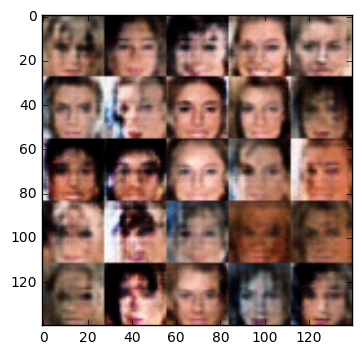

Epoch 1/1... Batch 910... Discriminator Loss: 1.2589... Generator Loss: 1.0855
Epoch 1/1... Batch 920... Discriminator Loss: 1.1497... Generator Loss: 1.4622
Epoch 1/1... Batch 930... Discriminator Loss: 0.7926... Generator Loss: 1.3259
Epoch 1/1... Batch 940... Discriminator Loss: 1.5005... Generator Loss: 0.4304
Epoch 1/1... Batch 950... Discriminator Loss: 1.2466... Generator Loss: 0.6104
Epoch 1/1... Batch 960... Discriminator Loss: 1.4556... Generator Loss: 1.5312
Epoch 1/1... Batch 970... Discriminator Loss: 1.1940... Generator Loss: 0.6972
Epoch 1/1... Batch 980... Discriminator Loss: 1.4603... Generator Loss: 0.5307
Epoch 1/1... Batch 990... Discriminator Loss: 1.2470... Generator Loss: 0.7224
Epoch 1/1... Batch 1000... Discriminator Loss: 1.3228... Generator Loss: 0.6562


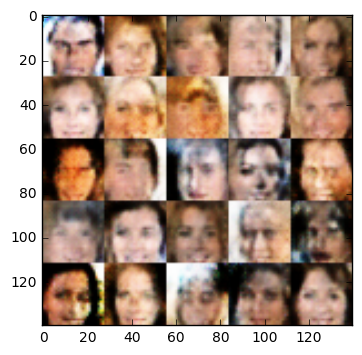

Epoch 1/1... Batch 1010... Discriminator Loss: 1.9018... Generator Loss: 1.8086
Epoch 1/1... Batch 1020... Discriminator Loss: 1.5063... Generator Loss: 0.9451
Epoch 1/1... Batch 1030... Discriminator Loss: 1.2369... Generator Loss: 1.1816
Epoch 1/1... Batch 1040... Discriminator Loss: 1.1795... Generator Loss: 0.6998
Epoch 1/1... Batch 1050... Discriminator Loss: 1.0528... Generator Loss: 0.8684
Epoch 1/1... Batch 1060... Discriminator Loss: 1.4587... Generator Loss: 2.7934
Epoch 1/1... Batch 1070... Discriminator Loss: 0.9402... Generator Loss: 1.0204
Epoch 1/1... Batch 1080... Discriminator Loss: 1.4189... Generator Loss: 0.6796
Epoch 1/1... Batch 1090... Discriminator Loss: 1.4284... Generator Loss: 0.5181
Epoch 1/1... Batch 1100... Discriminator Loss: 1.1009... Generator Loss: 1.0722


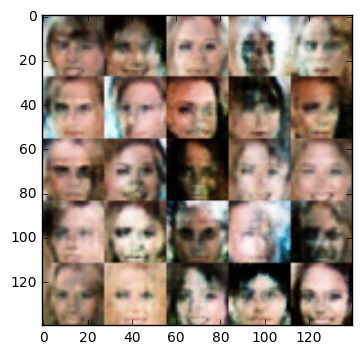

Epoch 1/1... Batch 1110... Discriminator Loss: 1.3445... Generator Loss: 0.5557
Epoch 1/1... Batch 1120... Discriminator Loss: 1.3647... Generator Loss: 0.6508
Epoch 1/1... Batch 1130... Discriminator Loss: 1.3187... Generator Loss: 0.7256


In [16]:
batch_size = 64
z_dim = 128
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.